## import

In [1]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader

from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.models.global_conv import \
    GlobalConvolutionNetwork

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/global-convolution")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 8
IMAGE_SIZE = 512
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

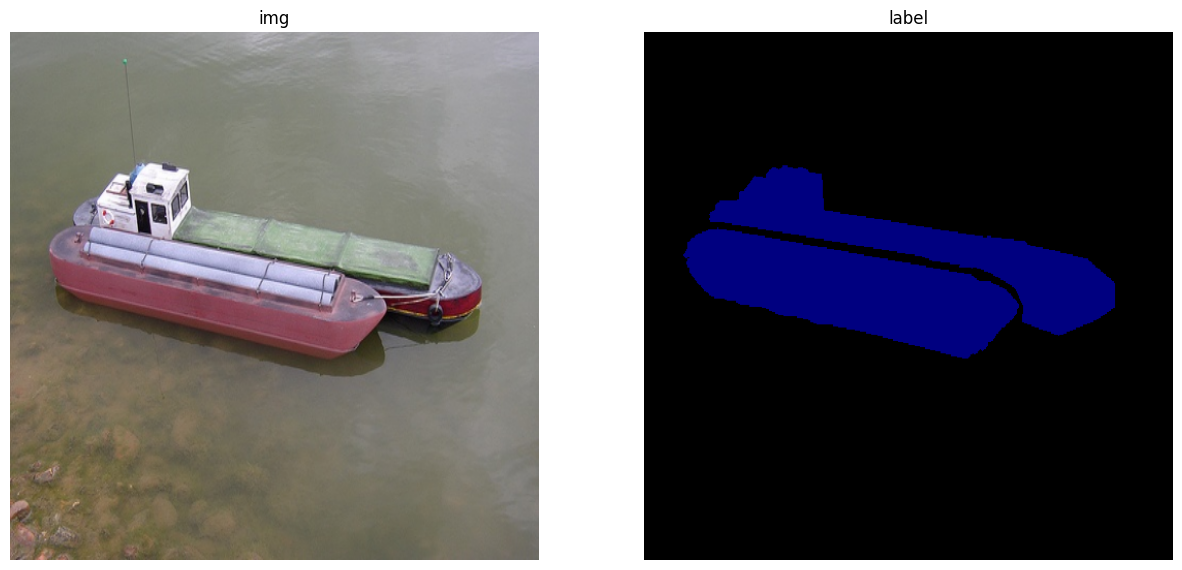

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [10]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([8, 3, 512, 512])
torch.Size([8, 512, 512])


# model

In [11]:
backbone = ResNetFeatureExtractor("resnet152", trainable=True)
model = GlobalConvolutionNetwork(backbone, output_size=NUM_CLASS + 1, kernel=15).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                       Param #
GlobalConvolutionNetwork                                     --
├─ResNetFeatureExtractor: 1-1                                --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2d: 3-1                                      9,408
│    │    └─BatchNorm2d: 3-2                                 128
│    │    └─ReLU: 3-3                                        --
│    │    └─MaxPool2d: 3-4                                   --
│    │    └─Sequential: 3-5                                  215,808
│    │    └─Sequential: 3-6                                  2,339,840
│    │    └─Sequential: 3-7                                  40,613,888
│    │    └─Sequential: 3-8                                  14,964,736
│    └─ImageNetNormalization: 2-2                            --
├─ModuleList: 1-2                                            --
│    └─Sequential: 2-3                                       --
│  

# train

In [13]:
EPOCHS = 30

In [14]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [17]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 364/364 [06:26<00:00,  1.06s/it]


------------------------------------
Epoch 1
------------------------------------
total: 9.5091e-02 (0.00%)


100%|██████████| 364/364 [03:30<00:00,  1.73it/s]


------------------------------------
Epoch 2
------------------------------------
total: 4.0494e-02 (-57.00%)


100%|██████████| 364/364 [02:50<00:00,  2.14it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.7773e-02 (-31.00%)


100%|██████████| 364/364 [02:24<00:00,  2.51it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.2148e-02 (-20.00%)


100%|██████████| 364/364 [02:24<00:00,  2.51it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.8351e-02 (-17.00%)


100%|██████████| 364/364 [02:24<00:00,  2.52it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.6956e-02 (-8.00%)


100%|██████████| 364/364 [02:24<00:00,  2.51it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.5638e-02 (-8.00%)


100%|██████████| 364/364 [02:24<00:00,  2.51it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.3459e-02 (-14.00%)


100%|██████████| 364/364 [02:24<00:00,  2.52it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.0982e-02 (-18.00%)


100%|██████████| 364/364 [02:52<00:00,  2.11it/s]


------------------------------------
Epoch 10
------------------------------------
total: 1.0493e-02 (-4.00%)


100%|██████████| 364/364 [03:18<00:00,  1.83it/s]


------------------------------------
Epoch 11
------------------------------------
total: 1.2116e-02 (15.00%)


100%|██████████| 364/364 [03:26<00:00,  1.76it/s]


------------------------------------
Epoch 12
------------------------------------
total: 1.5830e-02 (31.00%)


100%|██████████| 364/364 [03:18<00:00,  1.83it/s]


------------------------------------
Epoch 13
------------------------------------
total: 1.1912e-02 (-25.00%)


100%|██████████| 364/364 [03:18<00:00,  1.84it/s]


------------------------------------
Epoch 14
------------------------------------
total: 9.4418e-03 (-21.00%)


100%|██████████| 364/364 [03:18<00:00,  1.83it/s]


------------------------------------
Epoch 15
------------------------------------
total: 7.9787e-03 (-15.00%)


100%|██████████| 364/364 [02:40<00:00,  2.27it/s]


------------------------------------
Epoch 16
------------------------------------
total: 7.6990e-03 (-4.00%)


100%|██████████| 364/364 [02:24<00:00,  2.51it/s]


------------------------------------
Epoch 17
------------------------------------
total: 7.5498e-03 (-2.00%)


100%|██████████| 364/364 [02:24<00:00,  2.51it/s]


------------------------------------
Epoch 18
------------------------------------
total: 7.0818e-03 (-6.00%)


100%|██████████| 364/364 [02:25<00:00,  2.51it/s]


------------------------------------
Epoch 19
------------------------------------
total: 8.0749e-03 (14.00%)


100%|██████████| 364/364 [02:25<00:00,  2.51it/s]


------------------------------------
Epoch 20
------------------------------------
total: 1.7666e-02 (119.00%)


100%|██████████| 364/364 [02:24<00:00,  2.51it/s]


------------------------------------
Epoch 21
------------------------------------
total: 9.3260e-03 (-47.00%)


100%|██████████| 364/364 [02:28<00:00,  2.45it/s]


------------------------------------
Epoch 22
------------------------------------
total: 7.6896e-03 (-18.00%)


100%|██████████| 364/364 [02:28<00:00,  2.45it/s]


------------------------------------
Epoch 23
------------------------------------
total: 6.5068e-03 (-15.00%)


100%|██████████| 364/364 [02:28<00:00,  2.46it/s]


------------------------------------
Epoch 24
------------------------------------
total: 6.0815e-03 (-7.00%)


100%|██████████| 364/364 [02:29<00:00,  2.43it/s]


------------------------------------
Epoch 25
------------------------------------
total: 5.8252e-03 (-4.00%)


100%|██████████| 364/364 [02:26<00:00,  2.48it/s]


------------------------------------
Epoch 26
------------------------------------
total: 5.6215e-03 (-3.00%)


100%|██████████| 364/364 [02:31<00:00,  2.40it/s]


------------------------------------
Epoch 27
------------------------------------
total: 5.7055e-03 (1.00%)


100%|██████████| 364/364 [02:29<00:00,  2.43it/s]


------------------------------------
Epoch 28
------------------------------------
total: 5.5524e-03 (-3.00%)


100%|██████████| 364/364 [02:29<00:00,  2.43it/s]


------------------------------------
Epoch 29
------------------------------------
total: 6.6676e-03 (20.00%)


100%|██████████| 364/364 [02:26<00:00,  2.49it/s]

------------------------------------
Epoch 30
------------------------------------
total: 2.1605e-02 (224.00%)


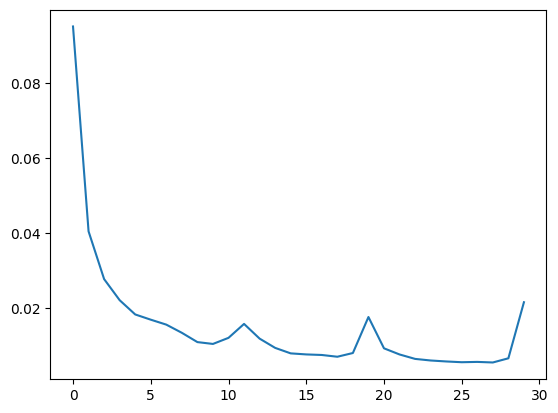

In [18]:
plt.plot(training_loss)

In [19]:
wm = WeightManager(artifacts_path.joinpath('global-convolution.{backbone}.pth').as_posix())

In [20]:
model_path = wm.get_filename(backbone=backbone.network_name)
model_path

WindowsPath('../../artifacts/global-convolution/global-convolution.resnet152.pth')

In [21]:
torch.save(model.state_dict(), model_path)

In [22]:
get_file_size(model_path)

'232.58MiB'

In [23]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### mIOU

In [24]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [25]:
evaluator = ClassificationEvaluator(NUM_CLASS+1, DEVICE)

In [26]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 158/158 [00:57<00:00,  2.75it/s]


In [27]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.9  
bicycle        : 0.69 
bird           : 0.92 
boat           : 0.86 
bottle         : 0.9  
bus            : 0.95 
car            : 0.91 
cat            : 0.93 
chair          : 0.75 
cow            : 0.91 
diningtable    : 0.89 
dog            : 0.89 
horse          : 0.86 
motorbike      : 0.88 
person         : 0.9  
pottedplant    : 0.69 
sheep          : 0.9  
sofa           : 0.86 
train          : 0.88 
tvmonitor      : 0.87 
----------------------
total          : 0.87 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

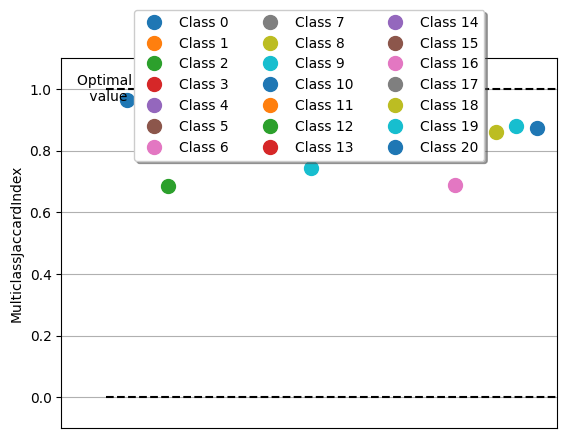

In [28]:
metric.plot()

### for image in dataset

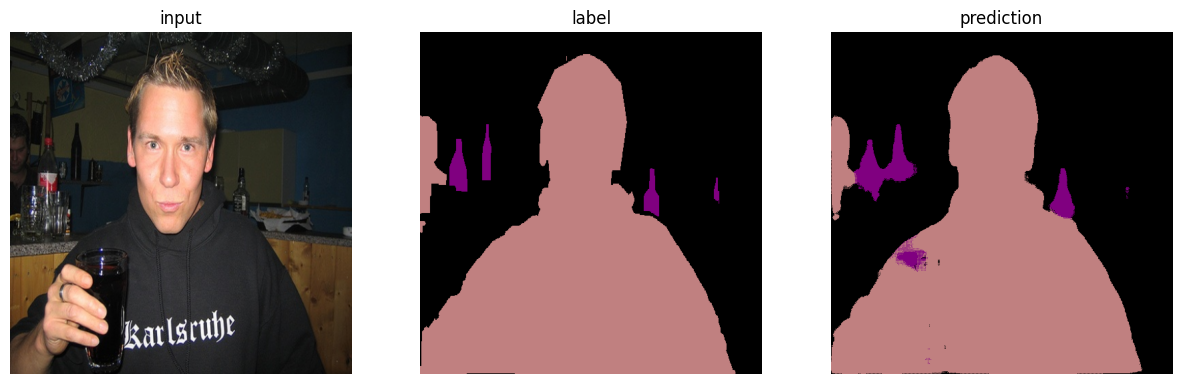

In [29]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

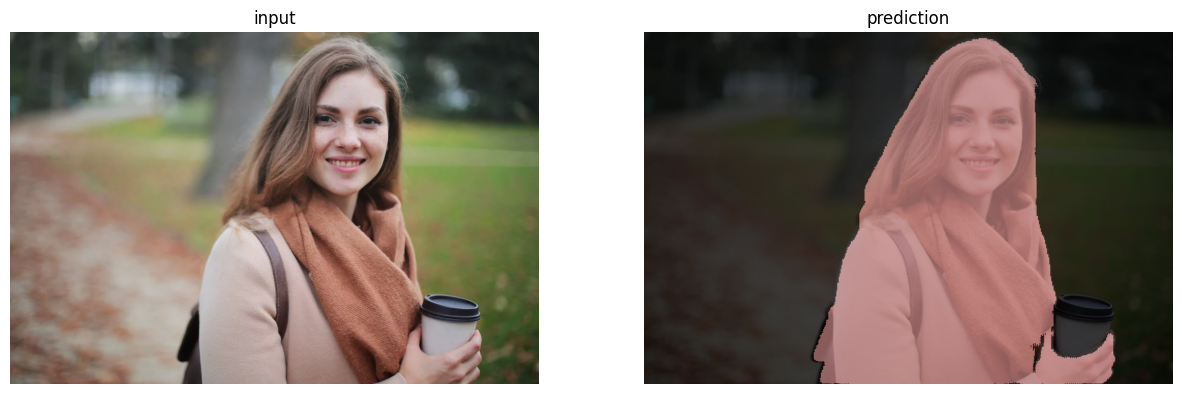

In [30]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )